# Automatic Feature Generation for PPO
This tutorial shows how automatic feature generation is conducted with OpenFE library.

In [ ]:
!git clone -b 1.0.0 https://github.com/TradeMaster-NTU/TradeMaster.git

Cloning into 'TradeMaster'...
remote: Enumerating objects: 6561, done.
remote: Total 6561 (delta 0), reused 0 (delta 0), pack-reused 6561
Receiving objects: 100% (6561/6561), 382.93 MiB | 22.83 MiB/s, done.
Resolving deltas: 100% (3393/3393), done.
Updating files: 100% (400/400), done.


In [ ]:
%cd '/content/TradeMaster'

/content/TradeMaster


In [ ]:
!pip install -r requirements.txt

## Step1: Import Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
from pathlib import Path
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from openfe import OpenFE, transform

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.utils import plot
from trademaster.utils import set_seed
set_seed(2023)

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
2023-05-09 15:50:12,657	INFO worker.py:973 -- Calling ray.init() again after it has already been called.


## Step2: Feature Generation

In [ ]:
path = 'data/portfolio_management/dj30/'
df_train = pd.read_csv(path + "train.csv")
df_valid = pd.read_csv(path + "valid.csv")
df_test = pd.read_csv(path + "test.csv")
tech_indicator_list = [
    "zopen",
    "zhigh",
    "zlow",
    "zadjcp",
    "zclose",
    "zd_5",
    "zd_10",
    "zd_15",
    "zd_20",
    "zd_25",
    "zd_30"
]

train_x = pd.DataFrame(df_train[tech_indicator_list])
valid_x = pd.DataFrame(df_valid[tech_indicator_list])
test_x = pd.DataFrame(df_test[tech_indicator_list])

X = pd.DataFrame(df_train[tech_indicator_list][:-1])
Y = pd.DataFrame({"close": list(df_train['close'][1:])})

n_jobs=4
ofe = OpenFE()
ofe.fit(data=X, label=Y, n_jobs=n_jobs)
train_x, valid_x = transform(train_x, valid_x, ofe.new_features_list[:10], n_jobs=n_jobs) 
X, test_x = transform(X, test_x, ofe.new_features_list[:10], n_jobs=n_jobs)

The number of candidate features is 418
Start stage I selection.


100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


35 same features have been deleted.
Meet early-stopping in successive feature-wise halving.


100%|██████████| 16/16 [00:41<00:00,  2.57s/it]


The number of remaining candidate features is 352
Start stage II selection.


100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


Finish data processing.


In [ ]:
new_df_train = pd.read_csv(path + "train.csv", index_col=[0])
new_df_valid = pd.read_csv(path + "valid.csv", index_col=[0])
new_df_test = pd.read_csv(path + "test.csv", index_col=[0])

new_features = ['autoFE_f_0', 'autoFE_f_1', 'autoFE_f_2',
       'autoFE_f_3', 'autoFE_f_4', 'autoFE_f_5', 'autoFE_f_6', 'autoFE_f_7',
       'autoFE_f_8', 'autoFE_f_9']

new_df_train = pd.merge(new_df_train, train_x[new_features], left_index=True, right_index=True)
new_df_train.to_csv(path + "new_train.csv", index=True)
new_df_valid = pd.merge(new_df_valid, valid_x[new_features], left_index=True, right_index=True)
new_df_valid.to_csv(path + "new_valid.csv", index=True)
new_df_test = pd.merge(new_df_test, test_x[new_features], left_index=True, right_index=True)
new_df_test.to_csv(path + "new_test.csv", index=True)

## Step3: Import Configs

In [ ]:
parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "TradeMaster", "configs", "portfolio_management", "portfolio_management_dj30_ppo_ppo_adam_mse_fg.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _ = parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

## Step4: Build Dataset

In [ ]:
dataset = build_dataset(cfg)

## Step5: Build Trainer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
work_dir = os.path.join(ROOT, "TradeMaster", cfg.trainer.work_dir)

if not os.path.exists(work_dir):
    os.makedirs(work_dir)
cfg.dump(osp.join(work_dir, osp.basename(args.config)))

trainer = build_trainer(cfg, default_args=dict(dataset=dataset, device = device))

2023-05-09 16:00:55,228	WARNING compression.py:17 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.


| Arguments Keep work_dir: /content/drive/MyDrive/TradeMaster/work_dir/portfolio_management_dj30_ppo_ppo_adam_mse_fg


## Step6: Train and Valid

In [ ]:
import ray
from ray.tune.registry import register_env
from trademaster.environments.portfolio_management.environment import PortfolioManagementEnvironment
def env_creator(env_name):
    if env_name == 'portfolio_management':
        env = PortfolioManagementEnvironment
    else:
        raise NotImplementedError
    return env
ray.init(ignore_reinit_error=True)
register_env("portfolio_management", lambda config: env_creator("portfolio_management")(config))
trainer.train_and_valid()

2023-05-09 16:00:56,598	INFO worker.py:973 -- Calling ray.init() again after it has already been called.
2023-05-09 16:00:56,617	INFO logger.py:188 -- pip install "ray[tune]" to see TensorBoard files.
2023-05-09 16:00:56,619	WARNING logger.py:336 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2023-05-09 16:00:56,624	INFO trainer.py:2321 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set eager_tracing=True  in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
2023-05-09 16:00:56,634	INFO trainer.py:903 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2023-05-09 16:00:57,649	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horiz

Train Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -86.547540%  |  -1.847291  | 0.827679%  |  87.620708%  |
+--------------+-------------+------------+--------------+


2023-05-09 16:02:16,054	WARNING deprecation.py:46 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
2023-05-09 16:02:16,058	WARNING deprecation.py:46 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Valid Episode: [1/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  6.795733%   |   0.364199  | 2.155261%  |  32.487321%  |
+--------------+-------------+------------+--------------+
Train Episode: [2/2]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -89.195716%  |  -1.997400  | 0.850551%  |  89.898235%  |
+--------------+-------------+------------+--------------+
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
| -86.575989%  |  -1.829999  | 0.835840%  |  87.083558%  |
+--------------+-------------+------------+--------------+
Valid Episode: [2/2]
+--------------+-------------+------------+---------

## Step7: Test

In [ ]:
import ray
from ray.tune.registry import register_env
from trademaster.environments.portfolio_management.environment import PortfolioManagementEnvironment
def env_creator(env_name):
    if env_name == 'portfolio_management':
        env = PortfolioManagementEnvironment
    else:
        raise NotImplementedError
    return env
ray.init(ignore_reinit_error=True)
register_env("portfolio_management", lambda config: env_creator("portfolio_management")(config))
trainer.test()

2023-05-09 16:06:40,156	WARNING env.py:135 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-05-09 16:06:40,940	WARNING util.py:65 -- Install gputil for GPU system monitoring.
2023-05-09 16:06:41,025	WARNING eager_tf_policy.py:724 -- Cannot restore an optimizer's state for tf eager! Keras is not able to save the v1.x optimizers (from tf.compat.v1.train) since they aren't compatible with checkpoints.
2023-05-09 16:06:41,565	INFO trainable.py:588 -- Restored on 172.28.0.12 from checkpoint: /root/ray_results/PPOTrainer_portfolio_management_2023-05-09_16-06-37k1vxwqse/tmptnde9i0zrestore_from_object/checkpoint-2
2023-05-09 16:06:41,569	INFO trainable.py:597 -- Current state after restoring: {'_iteration': 2, '_timesteps_total': None, '_time_total': 313.05774760246277, '_episodes_total': 3}


Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  16.367416%  |   1.381897  | 0.724094%  |  6.696040%   |
+--------------+-------------+------------+--------------+


array([ 0.00000000e+00,  3.05970536e-03,  1.31899522e-02,  7.27648248e-03,
        1.39758913e-03, -1.03331490e-03,  2.14846361e-03,  1.62698265e-03,
       -4.60545304e-04, -6.31885346e-03,  3.28831921e-03,  7.88614397e-03,
        6.22040096e-05, -8.51388267e-03, -7.17811191e-04, -4.23127059e-04,
       -1.66106080e-02,  9.63072438e-03, -1.89121900e-02,  6.82263723e-03,
        1.28993435e-02,  7.38708685e-04,  1.17664077e-02,  4.13381752e-03,
        7.45895236e-03, -1.29415441e-03,  1.44970599e-03, -1.11693025e-04,
        1.32227505e-03,  3.14629247e-04,  3.56695529e-03, -3.23848260e-03,
       -1.33125246e-03,  4.87082169e-04,  8.89492177e-04,  1.18824585e-02,
       -1.57107024e-02, -1.53079021e-02,  1.78989222e-02, -4.97593173e-03,
       -3.00781952e-03, -1.08432142e-02,  1.88646063e-02,  9.36838398e-03,
        1.54327368e-03,  1.35902662e-02,  4.67140772e-03,  7.04713378e-03,
        7.48075233e-03, -2.67507102e-03,  3.96961531e-03, -6.89318142e-03,
       -7.28553691e-03,  

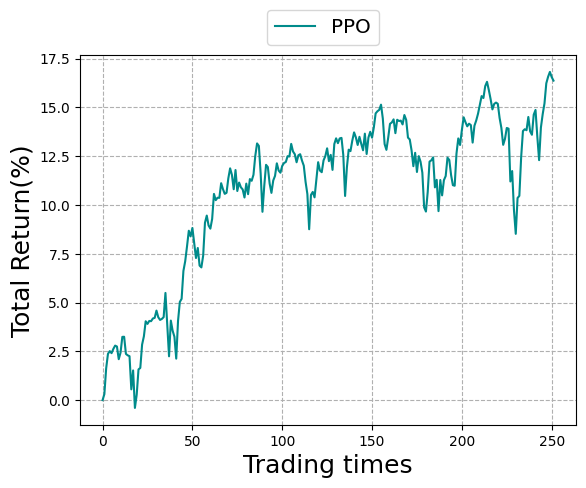

In [ ]:
plot(trainer.test_environment.save_asset_memory(),alg="PPO")